Projet Python 2025

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("alertes_enrichies.csv")
df.tail(5) # 5 derniers enregistrements (les plus récents)

,Titre Alerte,Type Alerte,Description Alerte,Lien Alerte,Date Alerte,CVE ID,Description CVE,CWE,Nature de la faille,Score CVSS,Gravité CVSS,Score EPSS,Gravité EPSS,Éditeur,Produit,Versions Affectées
35,Multiples vulnérabilités dans le noyau Linux d...,Avis,De multiples vulnérabilités ont été découverte...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Fri, 09 Jan 2026 00:00:00 +0000",CVE-2024-50095,"In the Linux kernel, the following vulnerabili...",Non disponible,Non disponible,NaN,Non disponible,0.00007,Faible,Linux,Linux,2.6.12
36,Multiples vulnérabilités dans le noyau Linux d...,Avis,De multiples vulnérabilités ont été découverte...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Fri, 09 Jan 2026 00:00:00 +0000",CVE-2023-53676,"In the Linux kernel, the following vulnerabili...",Non disponible,Non disponible,NaN,Non disponible,0.00045,Faible,Linux,Linux,3.1
37,Multiples vulnérabilités dans les produits IBM...,Avis,De multiples vulnérabilités ont été découverte...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Fri, 09 Jan 2026 00:00:00 +0000",CVE-2025-36000,IBM WebSphere Application Server Liberty 17.0....,CWE-79,CWE-79 Improper Neutralization of Input During...,4.4,Moyenne,0.00015,Faible,IBM,WebSphere Application Server Liberty,17.0.0.3
38,Vulnérabilité dans Microsoft Edge (09 janvier ...,Avis,Une vulnérabilité a été découverte dans Micros...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Fri, 09 Jan 2026 00:00:00 +0000",CVE-2025-62224,User interface (ui) misrepresentation of criti...,CWE-451,CWE-451: User Interface (UI) Misrepresentation...,5.5,Moyenne,0.00062,Faible,Microsoft,Microsoft Edge for Android,1.0.0
39,Multiples vulnérabilités dans les produits Mic...,Avis,De multiples vulnérabilités ont été découverte...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Fri, 09 Jan 2026 00:00:00 +0000",CVE-2025-11964,"On Windows only, if libpcap needs to convert a...",CWE-787,CWE-787 Out-of-bounds Write,1.9,Faible,0.00015,Faible,The Tcpdump Group,libpcap,1.10.0


Etape 5 : Interprétation et visualisation

Shape: (40, 16)
Valeurs manquantes par colonne:
 Titre Alerte            0
Type Alerte             0
Description Alerte      0
Lien Alerte             0
Date Alerte             0
CVE ID                  0
Description CVE         2
CWE                     0
Nature de la faille     3
Score CVSS             26
Gravité CVSS            0
Score EPSS              2
Gravité EPSS            0
Éditeur                 4
Produit                 3
Versions Affectées      3
dtype: int64


/var/folders/kp/j1c9d35x2ql0126h0tyh5_t80000gn/T/ipykernel_984/191739847.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  alerts_per_month = ts.resample('M').size()


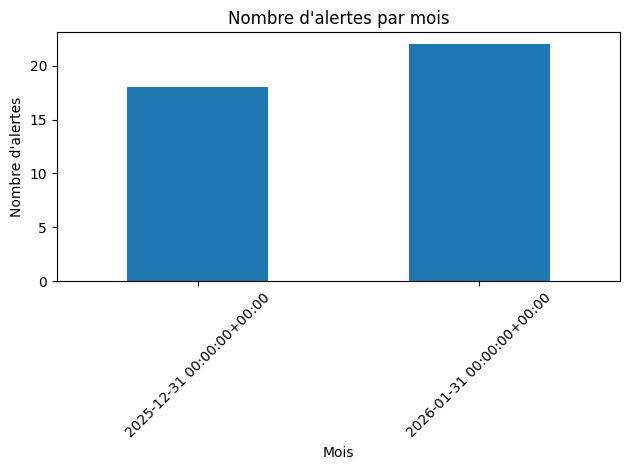

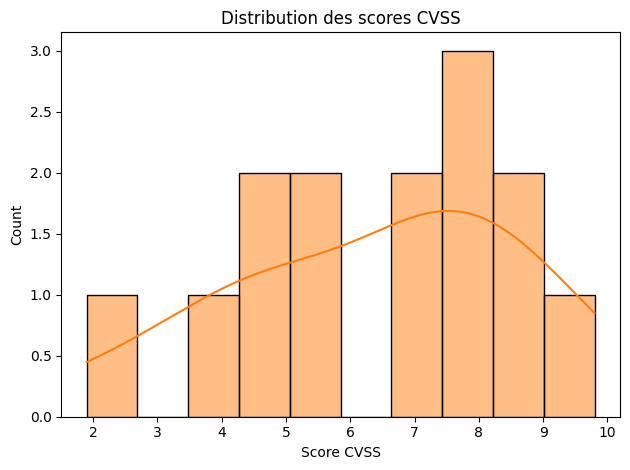

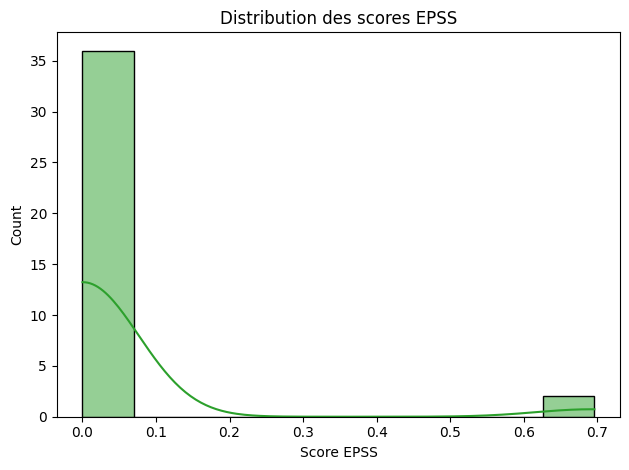

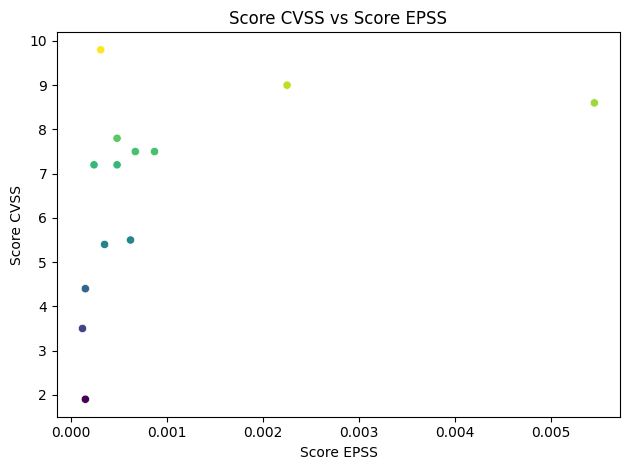

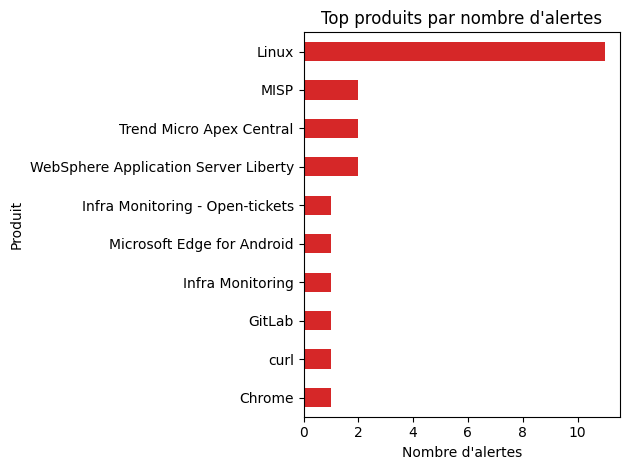

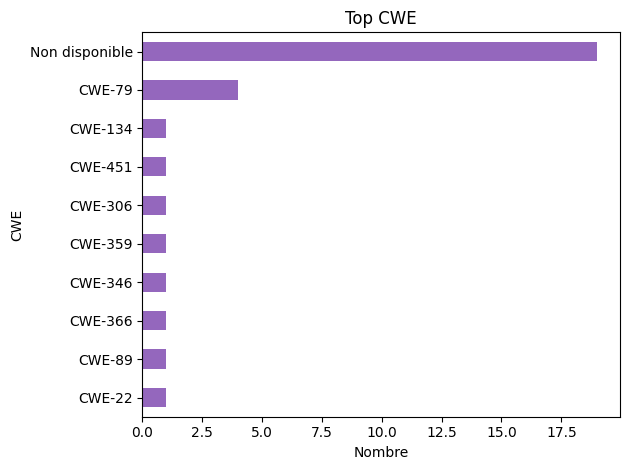

Nombre d'alertes Critiques/Élevées identifiées: 4
CVE-2025-14847 | CVSS: nan (Non disponible) | EPSS: 0.69622 (Élevée) | Produit: MongoDB Server
CVE-2025-59470 | CVSS: 9.0 (Critique) | EPSS: 0.00225 (Faible) | Produit: Backup and Recovery
CVE-2025-15026 | CVSS: 9.8 (Critique) | EPSS: 0.00031 (Faible) | Produit: Infra Monitoring
CVE-2023-38408 | CVSS: nan (Non disponible) | EPSS: 0.68749 (Élevée) | Produit: nan


,CVE ID,Score CVSS,Gravité CVSS,Produit
32,CVE-2025-15026,9.8,Critique,Infra Monitoring
23,CVE-2025-59470,9.0,Critique,Backup and Recovery
5,CVE-2024-38286,8.6,Élevée,Apache Tomcat
4,CVE-2025-66494,7.8,Élevée,Foxit PDF Editor
3,CVE-2024-21538,7.5,Élevée,org.webjars.npm:cross-spawn
29,CVE-2025-69260,7.5,Élevée,Trend Micro Apex Central
2,CVE-2025-68460,7.2,Élevée,Webmail
22,CVE-2025-12514,7.2,Élevée,Infra Monitoring - Open-tickets
38,CVE-2025-62224,5.5,Moyenne,Microsoft Edge for Android
0,CVE-2025-67906,5.4,Moyenne,MISP


Répartition des niveaux de risque calculés:
Niveau de risque calculé
Faible/Non disponible    28
Élevée                    6
Moyenne                   4
Critique                  2
Name: count, dtype: int64

Exemples d'interprétations (top 10 par niveau de risque & EPSS):
CVE-2024-38286: Multiples vulnérabilités dans les produits IBM (19 décembre 2025)... -> Niveau: Élevée, CVSS: 8.6, EPSS: 0.00545
CVE-2025-69260: Multiples vulnérabilités dans Trend Micro Apex Central (08 janvier 2026)... -> Niveau: Élevée, CVSS: 7.5, EPSS: 0.00087
CVE-2024-21538: Multiples vulnérabilités dans les produits VMware (19 décembre 2025)... -> Niveau: Élevée, CVSS: 7.5, EPSS: 0.00067
CVE-2025-68460: Multiples vulnérabilités dans Roundcube (15 décembre 2025)... -> Niveau: Élevée, CVSS: 7.2, EPSS: 0.00048
CVE-2025-66494: Multiples vulnérabilités dans les produits Foxit (19 décembre 2025)... -> Niveau: Élevée, CVSS: 7.8, EPSS: 0.00048
CVE-2025-12514: Multiples vulnérabilités dans Centreon Open Tickets (06 janvi

In [2]:
# Parcours et interprétation du dataframe + visualisations (utilise pd, plt, sns déjà importés)

# 1) Pré-traitement
df['Date Alerte'] = pd.to_datetime(df['Date Alerte'], errors='coerce')  # parser la date
print("Shape:", df.shape)
print("Valeurs manquantes par colonne:\n", df.isnull().sum())

# 2) Série temporelle: nombre d'alertes par mois
ts = df.set_index('Date Alerte').sort_index()
alerts_per_month = ts.resample('M').size()
alerts_per_month.plot(kind='bar', color='C0')
plt.title("Nombre d'alertes par mois")
plt.ylabel("Nombre d'alertes")
plt.xlabel("Mois")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3) Distribution des scores CVSS et EPSS
plt.figure()
sns.histplot(df['Score CVSS'].dropna(), bins=10, kde=True, color='C1')
plt.title("Distribution des scores CVSS")
plt.xlabel("Score CVSS")
plt.tight_layout()
plt.show()

plt.figure()
sns.histplot(df['Score EPSS'].dropna(), bins=10, kde=True, color='C2')
plt.title("Distribution des scores EPSS")
plt.xlabel("Score EPSS")
plt.tight_layout()
plt.show()

# 4) Corrélation/nuage: Score EPSS vs Score CVSS (points avec deux scores disponibles)
scatter_df = df[['CVE ID', 'Score CVSS', 'Score EPSS']].dropna()
plt.figure()
sns.scatterplot(data=scatter_df, x='Score EPSS', y='Score CVSS', hue='Score CVSS', palette='viridis', legend=False)
plt.title("Score CVSS vs Score EPSS")
plt.xlabel("Score EPSS")
plt.ylabel("Score CVSS")
plt.tight_layout()
plt.show()

# 5) Top produits / éditeurs / CWE (comptages)
plt.figure()
df['Produit'].value_counts().nlargest(10).plot(kind='barh', color='C3')
plt.title("Top produits par nombre d'alertes")
plt.xlabel("Nombre d'alertes")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

plt.figure()
df['CWE'].value_counts().nlargest(10).plot(kind='barh', color='C4')
plt.title("Top CWE")
plt.xlabel("Nombre")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 6) Filtrer les alertes critiques / élevées pour inspection
crit_mask = (
    (df['Score CVSS'].fillna(-1) >= 9) |
    (df['Gravité CVSS'].str.contains('Critique', na=False)) |
    (df['Gravité EPSS'].str.contains('Élevée', na=False))
)
crit_alerts = df[crit_mask]
print(f"Nombre d'alertes Critiques/Élevées identifiées: {len(crit_alerts)}")
for _, r in crit_alerts.iterrows():
    print(f"{r['CVE ID']} | CVSS: {r['Score CVSS']} ({r['Gravité CVSS']}) | EPSS: {r['Score EPSS']} ({r['Gravité EPSS']}) | Produit: {r['Produit']}")

# 7) Classement par score CVSS (top 10)
top_cvss = df.sort_values('Score CVSS', ascending=False).head(10)[['CVE ID','Score CVSS','Gravité CVSS','Produit']]
display(top_cvss)

# 8) Interprétation simple: calcul d'un niveau de risque à partir du CVSS
def niveau_risque(row):
    sc = row['Score CVSS']
    if pd.notna(sc):
        if sc >= 9:
            return 'Critique'
        if sc >= 7:
            return 'Élevée'
        if sc >= 4:
            return 'Moyenne'
    return 'Faible/Non disponible'

df['Niveau de risque calculé'] = df.apply(niveau_risque, axis=1)
print("Répartition des niveaux de risque calculés:")
print(df['Niveau de risque calculé'].value_counts())

# 9) exemples d'interprétations (quelques lignes)
print("\nExemples d'interprétations (top 10 par niveau de risque & EPSS):")
for _, r in df.sort_values(['Niveau de risque calculé','Score EPSS'], ascending=[False, False]).head(10).iterrows():
    print(f"{r['CVE ID']}: {r['Titre Alerte'][:80]}... -> Niveau: {r['Niveau de risque calculé']}, CVSS: {r['Score CVSS']}, EPSS: {r['Score EPSS']}")